In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d

from sivqed.models.siv import SiV
from sivqed.models.cavity import Cavity, CavitySiV

plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

# Empty cavity spectrum

In [2]:
freqs = np.linspace(-250, 250, 1000)

c = Cavity({"w_c" : 0, "k_in" : 43, "k_tot" : 65}, 
           {"w_up" : 0, "g_up" : 5.39, "gamma_up" : 0.05})
cavity_spectrum = c.reflectance(freqs, -1)
cavity_min = min(cavity_spectrum)

print(f"Cavity min = {cavity_min:.3}")
print(f"Cooperativity = {c.qubit_params['g_up']**2 / (c.cavity_params['k_tot'] * c.qubit_params['gamma_up']):.3}")

Cavity min = 0.104
Cooperativity = 8.94


## Fixed diffusion

### Plotting SiV peak contrast & SiV dip ratio (relative to cavity minimum)

In [141]:
def diffused_siv_peaks(cavity, detuning_freqs, diffusion_stdev, plot=True):
    siv_min = []
    siv_max = []
    diffused_siv_min = []
    diffused_siv_max = []
    
    # Number of steps in the freqs_filtered mesh so that it has
    # enough frequency resolution for the specified diffusion Gaussian
    # 30 comes from freqs_filtered width of 30
    # 5 comes from our desire for the Gaussian to have at least 5 stdev width in index space
    num_freq_steps = max(int(30 / (diffusion_stdev / 5)),  2000)
    freq_step = 30 / num_freq_steps
    
    if num_freq_steps > 10000:
        print("WARNING: The diffusion stdev is very small, so we will need a very fine frequency resolution to compute the convolution.")
        print(f"The current value of diffusion of {diffusion_stdev} requires {num_freq_steps} freq steps.")
    
    # Normalization to convert from stdev in freq-space to
    # stdev in the index value (depends on the freq-list step)
    diffusion_stdev_idx = diffusion_stdev / freq_step

    for idx, detuning in enumerate(detuning_freqs):
        # Set a particular value of detuning
        cavity.set_qubit_params({"w_up" : detuning})
        
        # Only crop the spectrum around the SiV resonance
        # This is necessary when computing the min/max for contrast, 
        # otherwise it would take the global min/max
        freqs_filtered = np.linspace(detuning - 15, detuning + 15, num_freq_steps)
        siv_filtered = cavity.reflectance(freqs_filtered, 1)
        
        # Compute the diffused spectrum
        diffused_siv_filtered = gaussian_filter1d(siv_filtered, diffusion_stdev_idx)
        
        # Plot the undiffused spectra and the diffused spectra at alternate spots
        if plot:
            if idx % 100 == 0:
                plt.plot(freqs_filtered, siv_filtered, 'b--', lw=1)
            if idx % 100 == 50:
                plt.plot(freqs_filtered, diffused_siv_filtered, 'g', lw=1)

        siv_min.append(min(siv_filtered))
        siv_max.append(max(siv_filtered))
        diffused_siv_min.append(min(diffused_siv_filtered))
        diffused_siv_max.append(max(diffused_siv_filtered))

    siv_min, siv_max = np.array(siv_min), np.array(siv_max)
    diffused_siv_min, diffused_siv_max = np.array(diffused_siv_min), np.array(diffused_siv_max)
    
    return siv_min, siv_max, diffused_siv_min, diffused_siv_max

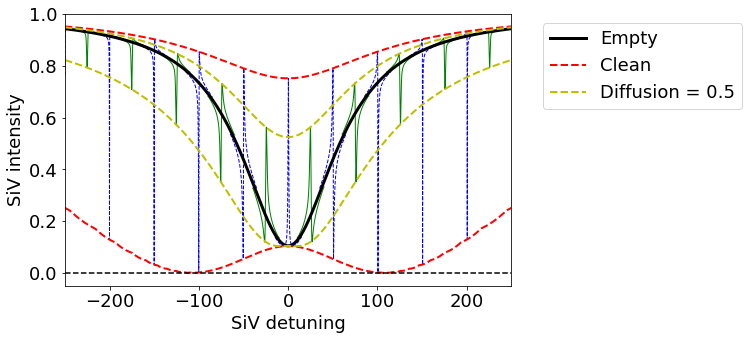

In [142]:
# Diffusion stdev using Gaussian filter
diffusion_stdev = 0.5
# List of SiV detunings to iterate over
detuning_freqs = np.linspace(-250, 250, 1000)

# Compute the siv min/max for clean and diffused!
siv_min, siv_max, diffused_siv_min, diffused_siv_max = diffused_siv_peaks(c, detuning_freqs, diffusion_stdev)
# Compute contrasts
siv_contrast = siv_max / siv_min
diffused_siv_contrast = diffused_siv_max / diffused_siv_min

# Plot the empty cavity spectrum
plt.plot(freqs, cavity_spectrum, 'k', lw=3, label="Empty")
# Plot the clean SiV spectrum envelope
plt.plot(detuning_freqs, siv_min, 'r--', lw=2, label="Clean")
plt.plot(detuning_freqs, siv_max, 'r--', lw=2)
# Plot the diffused SiV spectrum envelope
plt.plot(detuning_freqs, diffused_siv_min, 'y--', lw=2, label=f"Diffusion = {diffusion_stdev}")
plt.plot(detuning_freqs, diffused_siv_max, 'y--', lw=2)

plt.xlabel("SiV detuning")
plt.ylabel("SiV intensity")
plt.xlim(-250, 250)
plt.ylim(-0.05, 1.0)
plt.axhline(0.0, c='k', ls='--', lw=1.5)
plt.legend(bbox_to_anchor=(1.05, 1))

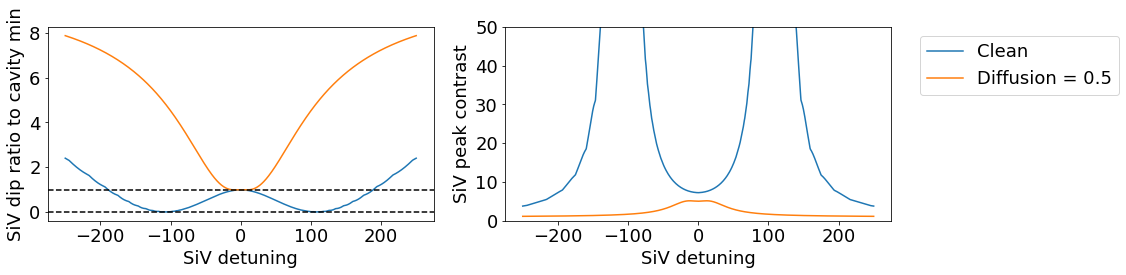

In [99]:
fig, ax = plt.subplots(1, 2, figsize=[16, 4])

ax[0].plot(detuning_freqs, siv_min / cavity_min, label="Clean")
ax[0].plot(detuning_freqs, diffused_siv_min / cavity_min, label=f"Diffusion = {diffusion_stdev}")
ax[0].axhline(0.0, c='k', ls='--', lw=1.5)
ax[0].axhline(1.0, c='k', ls='--', lw=1.5)
ax[0].set_xlabel("SiV detuning")
ax[0].set_ylabel("SiV dip ratio to cavity min")

ax[1].plot(detuning_freqs, siv_contrast, label="Clean")
ax[1].plot(detuning_freqs, diffused_siv_contrast, label=f"Diffusion = {diffusion_stdev}")
ax[1].set_xlabel("SiV detuning")
ax[1].set_ylabel("SiV peak contrast")
ax[1].set_ylim(0, 50)
ax[1].legend(bbox_to_anchor=(1.05, 1))

fig.tight_layout()

# Variable diffusion

In [151]:
# Diffusion stdev list
diffusion_stdev_list = np.geomspace(5e-3, 10, 8)
# List of SiV detunings to iterate over
detuning_freqs = np.linspace(-250, 250, 1000)

diffused_siv_min_list = []
diffused_siv_max_list = []

# Compute the siv min/max for clean and diffused!
for diffusion_stdev in diffusion_stdev_list:
    siv_min, siv_max, diffused_siv_min, diffused_siv_max = diffused_siv_peaks(c, detuning_freqs, diffusion_stdev, plot=False)
    
    diffused_siv_min_list.append(diffused_siv_min)
    diffused_siv_max_list.append(diffused_siv_max)
    
diffused_siv_min_list = np.array(diffused_siv_min_list)
diffused_siv_max_list = np.array(diffused_siv_max_list)

The current value of diffusion of 0.005 requires 30000 freq steps.
The current value of diffusion of 0.014809681479725867 requires 10128 freq steps.


In [162]:
def plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, diffused_siv_min_list, diffused_siv_max_list, cavity_min):
    # Compute contrasts
    diffused_siv_contrast_list = diffused_siv_max_list / diffused_siv_min_list
    
    fig, ax = plt.subplots(1, 2, figsize=[16, 5])
    for idx, diffusion_stdev in enumerate(diffusion_stdev_list):
        diffused_siv_min = diffused_siv_min_list[idx]
        diffused_siv_contrast = diffused_siv_contrast_list[idx]

        ax[0].plot(detuning_freqs, diffused_siv_min / cavity_min)
        ax[1].plot(detuning_freqs, diffused_siv_contrast, label=f"Diffusion = {diffusion_stdev:.1e}")

    ax[0].axhline(0.0, c='k', ls='--', lw=1.5)
    ax[0].axhline(1.0, c='k', ls='--', lw=1.5)
    ax[0].set_xlim(0, 250)
    ax[0].set_xlabel("SiV detuning")
    ax[0].set_ylabel("SiV dip ratio to cavity min")

    ax[1].set_xlabel("SiV detuning")
    ax[1].set_ylabel("SiV peak contrast")
    ax[1].set_xlim(0, 250)
    ax[1].set_ylim(0, 20)

    fig.legend(bbox_to_anchor=(1.2, 0.9))
    fig.tight_layout()

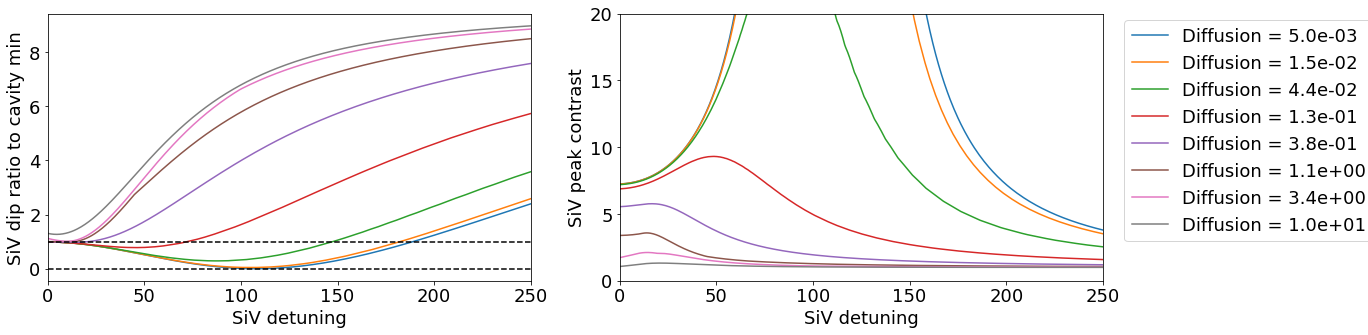

In [163]:
plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, diffused_siv_min_list, diffused_siv_max_list, cavity_min)

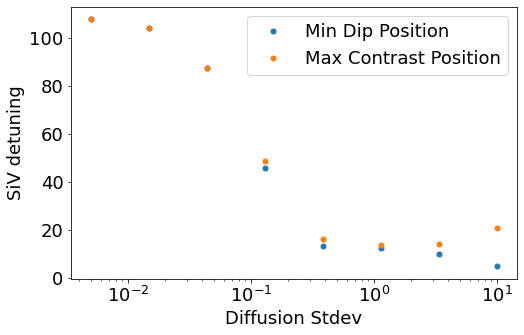

In [177]:
min_dip_positions = np.abs(detuning_freqs[np.argmin(diffused_siv_min_list, axis=1)])
max_contrast_positions = np.abs(detuning_freqs[np.argmax(diffused_siv_max_list / diffused_siv_min_list, axis=1)])

plt.semilogx(diffusion_stdev_list, min_dip_positions, '.', ms=10, label="Min Dip Position")
plt.semilogx(diffusion_stdev_list, max_contrast_positions, '.', ms=10, label="Max Contrast Position")
plt.xlabel("Diffusion Stdev")
plt.ylabel("SiV detuning")
plt.legend()

# Dark Counts

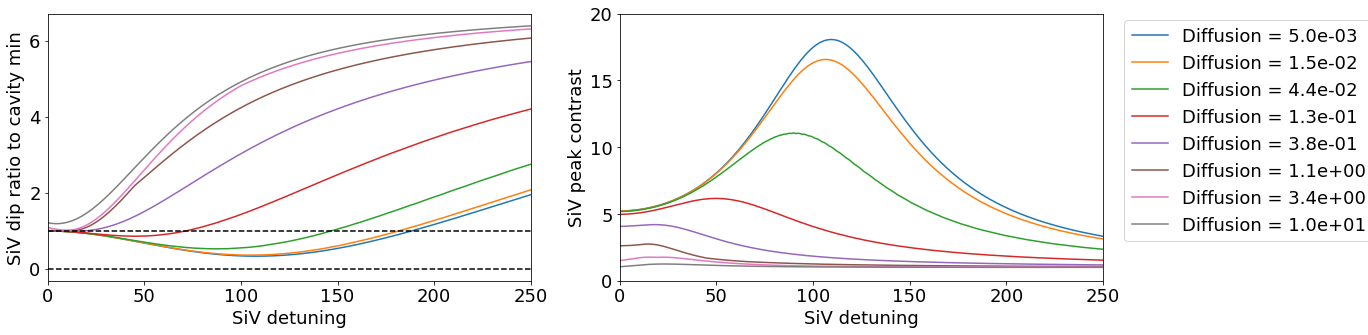

In [181]:
dark_counts = 0.05
plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, 
                        diffused_siv_min_list + dark_counts, 
                        diffused_siv_max_list + dark_counts, 
                        cavity_min + dark_counts)

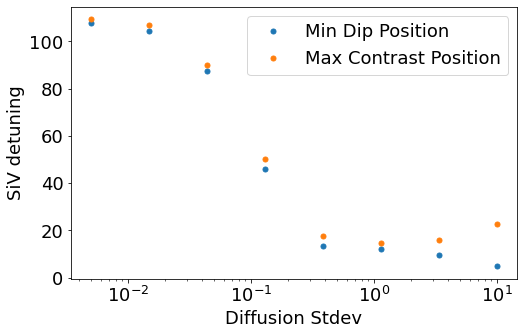

In [182]:
min_dip_positions = np.abs(detuning_freqs[np.argmin(diffused_siv_min_list, axis=1)])
max_contrast_positions = np.abs(detuning_freqs[np.argmax((diffused_siv_max_list + dark_counts) / (diffused_siv_min_list + dark_counts), axis=1)])

plt.semilogx(diffusion_stdev_list, min_dip_positions, '.', ms=10, label="Min Dip Position")
plt.semilogx(diffusion_stdev_list, max_contrast_positions, '.', ms=10, label="Max Contrast Position")
plt.xlabel("Diffusion Stdev")
plt.ylabel("SiV detuning")
plt.legend()

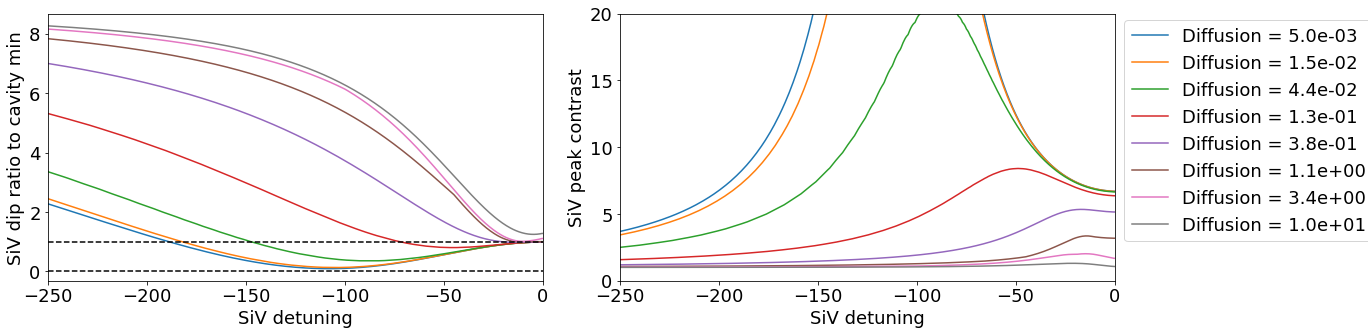

In [154]:
dark_counts = 0.01
plot_diffused_contrasts(detuning_freqs, diffusion_stdev_list, 
                        diffused_siv_min_list + dark_counts, 
                        diffused_siv_max_list + dark_counts, 
                        cavity_min + dark_counts)